## What is RecoGym?

RecoGym is a Python [OpenAI Gym](https://gym.openai.com/) environment for testing recommendation algorithms.  It allows for the testing of both offline and reinforcement-learning based agents.  It provides a way to test algorithms in a toy environment quickly.

In this notebook, we will code a simple recommendation agent that suggests an item in proportion to how many times it has been viewed.  We hope to inspire you to create your own agents and test them against our baseline models.

In order to make the most out of RecoGym, we suggest you have some experience coding in Python, some background knowledge in recommender systems, and familiarity with the reinforcement learning setup.  Also, be sure to check out the python-based requirements in the README if something below errors.

## Reinforcement Learning Setup

RecoGym follows the usual reinforcement learning setup.  This means there are interactions between the environment (the user's behaviour) and the agent (our recommendation algorithm).  The agent receives a reward if the user clicks on the recommendation.

<img src="https://github.com/criteo-research/reco-gym/blob/master/images/rl-setup.png?raw=1" alt="Drawing" style="width: 600px;"/>

## Organic and Bandit

Even though our focus is biased towards online advertising, we tried to make RecoGym universal to all types of recommendation.  Hence, we introduce the domain-agnostic terms Organic and Bandit sessions.  An Organic session is an observation of items the user interacts with.  For example, it could be views of products on an e-commerce website, listens to songs while streaming music, or readings of articles on an online newspaper.  A Bandit session is one where we have an opportunity to recommend the user an item and observe their behaviour.  We receive a reward if they click.

<img src="https://github.com/criteo-research/reco-gym/blob/master/images/organic-bandit.png?raw=1" alt="Drawing" style="width: 450px;"/>

## Offline and Online Learning

This project was born out of a desire to improve Criteo's recommendation system by exploring reinforcement learning algorithms. We quickly realised that we couldn't just blindly apply RL algorithms in a production system out of the box. The learning period would be too costly. Instead, we need to leverage the vast amounts of offline training examples we already to make the algorithm perform as good as the current system before releasing into the online production environment.

Thus, RecoGym follows a similar flow. An agent is first given access to many offline training examples produced from a fixed policy. Then, they have access to the online system where they choose the actions.

<img src="https://github.com/criteo-research/reco-gym/blob/master/images/two-steps.png?raw=1" alt="Drawing" style="width: 450px;"/>

## Let's see some code - Interacting with the environment 


The code snippet below shows how to initialise the environment and step through in an 'offline' manner (Here offline means that the environment is generating some recommendations for us).  We print out the results from the environment at each step.

In [ ]:
!pip install recogym

In [ ]:
import gym, recogym

# env_0_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_args, Configuration

# You can overwrite environment arguments here:
env_1_args['random_seed'] = 42
env_1_args['num_products'] = 1000

print(env_1_args)

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

# .reset() env before each episode (one episode per user).
env.reset()
done = False

# Counting how many steps.
i = 0

observation, reward, done = None, 0, False
while not done:
    action, observation, reward, done, info = env.step_offline(observation, reward, done)
    print(f"Step: {i} - Action: {action} - Observation: {observation.sessions()} - Reward: {reward}")
    i += 1

{'num_products': 1000, 'num_users': 100, 'random_seed': 42, 'prob_leave_bandit': 0.01, 'prob_leave_organic': 0.01, 'prob_bandit_to_organic': 0.05, 'prob_organic_to_bandit': 0.25, 'normalize_beta': False, 'with_ps_all': False, 'num_clusters': 2, 'phi_var': 0.1, 'K': 5, 'sigma_omega_initial': 1, 'sigma_omega': 0.1, 'number_of_flips': 0, 'sigma_mu_organic': 3, 'change_omega_for_bandits': False}
Step: 0 - Action: None - Observation: [{'t': 0, 'u': 0, 'z': 'pageview', 'v': 85}] - Reward: None
Step: 1 - Action: {'t': 1, 'u': 0, 'a': 99, 'ps': 0.001, 'ps-a': ()} - Observation: [] - Reward: 0
Step: 2 - Action: {'t': 2, 'u': 0, 'a': 308, 'ps': 0.001, 'ps-a': ()} - Observation: [] - Reward: 0
Step: 3 - Action: {'t': 3, 'u': 0, 'a': 805, 'ps': 0.001, 'ps-a': ()} - Observation: [] - Reward: 0


Okay, there's quite a bit going on here:  
- `action`, is a number between `0` and `num_products - 1` that references the index of the product recommended.   
- `observation` will either be `None` or a session of Organic data, showing the index of products the user views. 
- `reward` is 0 if the user does not click on the recommended product and 1 if they do.  Notice that when a user clicks on a product (Wherever the reward is 1), they start a new Organic session.
- `done` is a True/False flag indicating if the episode (aka user's timeline) is over.  
- `info` currently not used, so it is always an empty dictionary.

Also, notice that the first `action` is `None`.  In our implementation, the agent observes Organic behaviour before recommending anything.

Now, we will show calling the environment in an online manner, where the agent needs to supply an action. For demonstration purposes, we will create a list of hard-coded actions. 

In [ ]:
# Create list of hard coded actions.
actions = [None] + [1, 2, 3, 4, 5]

# Reset env and set done to False.
env.reset()
done = False

# Counting how many steps.
i = 0

while not done and i < len(actions):
    action = actions[i]
    observation, reward, done, info = env.step(action)
    print(f"Step: {i} - Action: {action} - Observation: {observation.sessions()} - Reward: {reward}")
    i += 1

Step: 0 - Action: None - Observation: [{'t': 0, 'u': 0, 'z': 'pageview', 'v': 796}] - Reward: None
Step: 1 - Action: 1 - Observation: [] - Reward: 0
Step: 2 - Action: 2 - Observation: [] - Reward: 0
Step: 3 - Action: 3 - Observation: [] - Reward: 0
Step: 4 - Action: 4 - Observation: [] - Reward: 0
Step: 5 - Action: 5 - Observation: [{'t': 6, 'u': 0, 'z': 'pageview', 'v': 796}, {'t': 7, 'u': 0, 'z': 'pageview', 'v': 796}, {'t': 8, 'u': 0, 'z': 'pageview', 'v': 796}, {'t': 9, 'u': 0, 'z': 'pageview', 'v': 796}, {'t': 10, 'u': 0, 'z': 'pageview', 'v': 796}, {'t': 11, 'u': 0, 'z': 'pageview', 'v': 796}, {'t': 12, 'u': 0, 'z': 'pageview', 'v': 796}, {'t': 13, 'u': 0, 'z': 'pageview', 'v': 796}, {'t': 14, 'u': 0, 'z': 'pageview', 'v': 796}, {'t': 15, 'u': 0, 'z': 'pageview', 'v': 796}, {'t': 16, 'u': 0, 'z': 'pageview', 'v': 796}, {'t': 17, 'u': 0, 'z': 'pageview', 'v': 24}, {'t': 18, 'u': 0, 'z': 'pageview', 'v': 796}, {'t': 19, 'u': 0, 'z': 'pageview', 'v': 796}, {'t': 20, 'u': 0, 'z': 'pa

You'll notice that the offline and online APIs are nearly identical.  The only difference is that one calls either env.step_offline() or env.step(action).

## Creating our first agent

Now that we see have seen how the offline and online versions of the environment work, it is time to code our first recommendation agent!  Technically, an agent can be anything that produces actions for the environment to use.  However, we will show you the object-oriented way we like to create agents.

Below is the code for a very simple agent - the popularity based agent. The popularity based agent records merely how many times a user sees each product organically, then when required to make a recommendation, the agent chooses a product randomly in proportion with a number of times the user has viewed it.

In [ ]:
import numpy as np
from numpy.random import choice
from recogym.agents import Agent

# Define an Agent class.
class PopularityAgent(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(PopularityAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.organic_views = np.zeros(self.config.num_products)

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Adding organic session to organic view counts.
        if observation:
            for session in observation.sessions():
                self.organic_views[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Choosing action randomly in proportion with number of views.
        prob = self.organic_views / sum(self.organic_views)
        action = choice(self.config.num_products, p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action]
            }
        }

The `PopularityAgent` class above demonstrates our preferred way to create agents for RecoGym. Notice how we have both a `train` and `act` method present. The `train` method is designed to take in training data from the environments `step_offline` method and thus has nothing to return, while the `act` method must return an action to pass back into the environment. 

The code below highlights how one would use this agent for first offline training and then using the learned knowledge to make recommendations online.

In [ ]:
# Instantiate instance of PopularityAgent class.
num_products = 1000
agent = PopularityAgent(Configuration({
    **env_1_args,
    'num_products': num_products,
}))

# Resets random seed back to 42, or whatever we set it to in env_0_args.
env.reset_random_seed()

# Train on 1000 users offline.
num_offline_users = 1000

for _ in range(num_offline_users):

    # Reset env and set done to False.
    env.reset()
    done = False

    observation, reward, done = None, 0, False
    while not done:
        old_observation = observation
        action, observation, reward, done, info = env.step_offline(observation, reward, done)
        agent.train(old_observation, action, reward, done)

# Train on 100 users online and track click through rate.
num_online_users = 100
num_clicks, num_events = 0, 0

for _ in range(num_online_users):

    # Reset env and set done to False.
    env.reset()
    observation, _, done, _ = env.step(None)
    reward = None
    done = None
    while not done:
        action = agent.act(observation, reward, done)
        observation, reward, done, info = env.step(action['a'])

        # Used for calculating click through rate.
        num_clicks += 1 if reward == 1 and reward is not None else 0
        num_events += 1

ctr = num_clicks / num_events

print(f"Click Through Rate: {ctr:.4f}")

Click Through Rate: 0.0211


## Testing our first agent

Now we have created our popularity based agent, and we should test it against an even simpler baseline - one that performs no learning and recommends products uniformly at random. To do this, we will first load a more complex version of the toy data environment called `reco-gym-v1`.

Next, we will load another agent for our agent to compete against each other. Here you can see we make use of the `RandomAgent` and create an instance of it in addition to our `PopularityAgent`.

In [ ]:
import gym, recogym
from recogym import env_1_args

from copy import deepcopy

env_1_args['random_seed'] = 42

env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

# Import the random agent.
from recogym.agents import RandomAgent, random_args

# Create the two agents.
num_products = env_1_args['num_products']
popularity_agent = PopularityAgent(Configuration(env_1_args))
agent_rand = RandomAgent(Configuration({
    **env_1_args,
    **random_args,
}))

Now we have instances of our two agents. We can use the `test_agent` method from RecoGym and compare there performance.

To use `test_agent`, one must provide a copy of the current env, a copy of the agent class, the number of training users and the number of testing users. 

In [ ]:
# Credible interval of the CTR median and 0.025 0.975 quantile.
recogym.test_agent(deepcopy(env), deepcopy(agent_rand), 1000, 1000)

Offline Users:   0%|          | 0/1000 [00:00<?, ?it/s]

Start: Agent Training #0


Online Users:   1%|          | 9/1000 [00:00<00:11, 86.85it/s]

Start: Agent Testing #0


Online Users: 100%|██████████| 1000/1000 [00:27<00:00, 36.93it/s]

End: Agent Testing #0 (53.527989864349365s)


(0.009399448768349045, 0.008734101723232421, 0.01009743054491552)

In [ ]:
# Credible interval of the CTR median and 0.025 0.975 quantile.
recogym.test_agent(deepcopy(env), deepcopy(popularity_agent), 1000, 1000) 

Offline Users:   0%|          | 0/1000 [00:00<?, ?it/s]

Start: Agent Training #0


Online Users:   0%|          | 4/1000 [00:00<00:29, 34.16it/s]

Start: Agent Testing #0


Online Users: 100%|██████████| 1000/1000 [00:44<00:00, 23.91it/s]

End: Agent Testing #0 (71.12142872810364s)


(0.021129952289653392, 0.02011222379366329, 0.022180696366972064)

We see an improvement in the click-through rate for the popularity agent.

In [ ]:
class OverallPopularityAgent(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(OverallPopularityAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.organic_views = np.zeros(self.config.num_products)

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Adding organic session to organic view counts.
        if observation:
            for session in observation.sessions():
                self.organic_views[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Choosing action randomly in proportion with number of views.
        prob = self.organic_views / sum(self.organic_views)
        action = choice(self.config.num_products, p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action]
            }
        }
    def infos(self):
        return self.organic_views

In [ ]:
import sys
class Logger:
    def __init__(self, level, out=sys.stdout):
        self.level = level
        self.out = out
    def log(self, content, level=0):
        if level <= self.level:
            self.out.write(str(content))
    def logn(self, content, level=0):
        self.log(str(content) + "\n", level)

In [ ]:
class ExperimentRunner:
    def __init__(self, env, agent, num_offline_users, num_online_users, verbose=0):
        self.env = env
        self.agent = agent
        self.num_offline_users = num_offline_users
        self.num_online_users = num_online_users
        self.logger = Logger(verbose)
    
    def run_offline(self):
        self.env.reset_random_seed()
        for _ in range(self.num_offline_users):
            # Reset env and set done to False.
            self.env.reset()
            done = False

            observation, reward, done = None, 0, False
            while not done:
                old_observation = observation
                action, observation, reward, done, info = self.env.step_offline(observation, reward, done)
                self.agent.train(old_observation, action, reward, done)

    def run_online(self):
        # Train on 100 users online and track click through rate.
        num_online_users = 100
        num_clicks, num_events = 0, 0

        for _ in range(num_online_users):

            # Reset env and set done to False.
            self.env.reset()
            observation, _, done, _ = self.env.step(None)
            reward = None
            done = None
            while not done:
                action = self.agent.act(observation, reward, done)
                observation, reward, done, info = self.env.step(action['a'])

                # Used for calculating click through rate.
                num_clicks += 1 if reward == 1 and reward is not None else 0
                num_events += 1

        ctr = num_clicks / num_events

        self.logger.logn(f"Click Through Rate: {ctr:.4f}")

    def run(self):
        self.run_offline()
        self.run_online()
        self.logger.logn(self.agent.infos())
        return self.agent.infos()

In [ ]:
num_products = env_1_args['num_products']
popularity_agent = OverallPopularityAgent(Configuration(env_1_args))
exp_run = ExperimentRunner(deepcopy(env), deepcopy(popularity_agent), 1000, 1000)
exp_run.run()

Click Through Rate: 0.0204
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 4.000e+00
 5.000e+00 0.000e+00 0.000e+00 6.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 2.100e+01 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.830e+02 0.000e+00 1.000e+00 0.000e+00
 7.000e+00 0.000e+00 0.000e+00 5.000e+00 0.000e+00 0.000e+00 1.000e+00
 8.020e+02 7.900e+01 0.000e+00 1.100e+01 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 0.000e+00 3.600e+01 4.000e+00 0.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+01 0.000e+00 9.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00
 0.000e+00 6.000e+00 0.000e+00 0.000e+00 1.400e+01 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 2.000e+00 1.000e+00 3.000e+01 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.100e+01 4.650e+02 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 8.000e+00 2.000e+00 1.000e+00

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       4.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.100e+01,
       0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.830e+02, 0.000e+00, 1.000e+00, 0.000e+00, 7.000e+00, 0.000e+00,
       0.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 8.020e+02,
       7.900e+01, 0.000e+00, 1.100e+01, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 3.600e+01, 4.000e+00, 0.000e+00, 1.000e+00,
       2.000e+00, 0.000e+00, 1.000e+01, 0.000e+00, 9.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 0.000e+00,
       0.000e+00, 1.400e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
       1.000e+00, 3.000e+01, 0.000e+00, 1.000e+00, 

In [ ]:
import numpy as np

class Graph:
    def __init__(self, num_items):
        self.adj = np.zeros((num_items, num_items))
    
    def add(self, from_node, to_node, value=1):
        self.adj[from_node, to_node] += value

    def __str__(self):
        return str(self.adj)
    
    def __repr__(self):
        return str(self)

In [ ]:
class SimpleGraphMatrixAgent(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(SimpleGraphMatrixAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.organic_views = Graph(self.config.num_products)

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Adding organic session to organic view counts.
        if observation:
            previous_item = None
            for session in observation.sessions():
                current_item = session['v']
                if previous_item is not None:
                    self.organic_views.add(previous_item, current_item)
                previous_item = current_item
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Choosing action randomly in proportion with number of views.
        if observation is not None and len(observation.current_sessions) > 0:
            current_items, counts = np.unique([sess['v'] for sess in observation.current_sessions], return_counts=True)
            probas = counts / np.sum(counts) # Numerical stability
            node = np.random.choice(current_items, p = probas)
            potentials = self.organic_views.adj[node, :]
            action = node
            #print(current_items, counts)
            #print(potentials)
            #prob = self.organic_views / sum(self.organic_views)
        else:
            action = choice(self.config.num_products)#, p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': 1 #prob[action]
            }
        }
    def infos(self):
        return self.organic_views

In [ ]:
num_products = env_1_args['num_products']
simple_graph_matrix_agent = SimpleGraphMatrixAgent(Configuration(env_1_args))
exp_run = ExperimentRunner(deepcopy(env), deepcopy(simple_graph_matrix_agent), 1000, 1000)
exp_run.run()

Click Through Rate: 0.0111
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [ ]:
class GraphMatrixAgent(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(GraphMatrixAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.organic_views = Graph(self.config.num_products)

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Adding organic session to organic view counts.
        if observation:
            previous_item = None
            for session in observation.sessions():
                current_item = session['v']
                if previous_item is not None:
                    self.organic_views.add(previous_item, current_item)
                previous_item = current_item
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""
        # Choosing action randomly in proportion with number of views.
        if observation is not None and len(observation.current_sessions) > 0:
            current_items, counts = np.unique([sess['v'] for sess in observation.current_sessions], return_counts=True)
            probas = counts / np.sum(counts) # Numerical stability
            node = np.random.choice(current_items, p = probas)
            potentials = self.organic_views.adj[node, :]
            action = node
            mask = np.ones(self.config.num_products)
            #mask[np.array(current_items)] = 0
            sum_potentials = np.sum(potentials * mask)
            if sum_potentials != 0:
                next_probas = (potentials * mask) / sum_potentials
                actions = np.random.choice(np.arange(len(potentials)), p = next_probas)
            else:
                action = choice(self.config.num_products)
            #prob = self.organic_views / sum(self.organic_views)
        else:
            action = choice(self.config.num_products)#, p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': 1 #prob[action]
            }
        }
    def infos(self):
        return self.organic_views

In [ ]:
num_products = env_1_args['num_products']
graph_matrix_agent = GraphMatrixAgent(Configuration(env_1_args))
exp_run = ExperimentRunner(deepcopy(env), deepcopy(graph_matrix_agent), 1000, 1000)
exp_run.run()

Click Through Rate: 0.0121
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [ ]:
class UnseenGraphMatrixAgent(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(UnseenGraphMatrixAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.organic_views = Graph(self.config.num_products)

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Adding organic session to organic view counts.
        if observation:
            previous_item = None
            for session in observation.sessions():
                current_item = session['v']
                if previous_item is not None:
                    self.organic_views.add(previous_item, current_item)
                previous_item = current_item
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""
        # Choosing action randomly in proportion with number of views.
        if observation is not None and len(observation.current_sessions) > 0:
            current_items, counts = np.unique([sess['v'] for sess in observation.current_sessions], return_counts=True)
            probas = counts / np.sum(counts) # Numerical stability
            node = np.random.choice(current_items, p = probas)
            potentials = self.organic_views.adj[node, :]
            action = node
            mask = np.ones(self.config.num_products)
            mask[np.array(current_items)] = 0
            sum_potentials = np.sum(potentials * mask)
            if sum_potentials != 0:
                next_probas = (potentials * mask) / sum_potentials
                actions = np.random.choice(np.arange(len(potentials)), p = next_probas)
            else:
                action = choice(self.config.num_products)
            #prob = self.organic_views / sum(self.organic_views)
        else:
            action = choice(self.config.num_products)#, p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': 1 #prob[action]
            }
        }
    def infos(self):
        return self.organic_views

In [ ]:
num_products = env_1_args['num_products']
unseen_graph_matrix_agent = UnseenGraphMatrixAgent(Configuration(env_1_args))
exp_run = ExperimentRunner(deepcopy(env), deepcopy(unseen_graph_matrix_agent), 1000, 1000)
exp_run.run()

Click Through Rate: 0.0112
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [ ]:
def test_agent(env, agent, offline=1000, online=1000):
    num_products = env_1_args['num_products']
    exp_run = ExperimentRunner(deepcopy(env), deepcopy(agent), offline, online)
    return exp_run.run()
test_agent(env, UnseenGraphMatrixAgent(Configuration(env_1_args)))

Click Through Rate: 0.0107
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [ ]:
recogym.test_agent(deepcopy(env), UnseenGraphMatrixAgent(Configuration(env_1_args)), 1000, 1000)

Offline Users:   0%|          | 0/1000 [00:00<?, ?it/s]

Start: Agent Training #0


Online Users:   1%|          | 9/1000 [00:00<00:11, 84.92it/s]

Start: Agent Testing #0


Online Users: 100%|██████████| 1000/1000 [00:28<00:00, 35.22it/s]

End: Agent Testing #0 (55.12728524208069s)


(0.011705780504272742, 0.01096036363171598, 0.012483844660423848)

In [ ]:
class RewardMaskGraphMatrixAgent(Agent):
    def __init__(self, config, penalty):
        # Set number of products as an attribute of the Agent.
        super(RewardMaskGraphMatrixAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.organic_views = Graph(self.config.num_products)
        self.current_user = None
        self.current_user_failed_reco = []
        self.last_reco = None
        self.penalty = penalty

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Adding organic session to organic view counts.
        if observation:
            previous_item = None
            for session in observation.sessions():
                current_item = session['v']
                if previous_item is not None:
                    self.organic_views.add(previous_item, current_item)
                previous_item = current_item

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""
        # Choosing action randomly in proportion with number of views.
        if observation is not None and len(observation.current_sessions) > 0:
            current_user = observation.current_sessions[-1]['u']
            if current_user != self.current_user:
                self.current_user = current_user
                self.current_user_failed_reco = []
                self.last_reco = None
            if reward is not None and reward == 0 and self.last_reco is not None:
                self.current_user_failed_reco.append(self.last_reco)

            current_items, counts = np.unique([sess['v'] for sess in observation.current_sessions], return_counts=True)
            probas = counts / np.sum(counts) # Numerical stability
            node = np.random.choice(current_items, p = probas)
            potentials = self.organic_views.adj[node, :]
            action = node
            mask = np.ones(self.config.num_products)
            #print(np.array(self.current_user_failed_reco))
            if len(self.current_user_failed_reco) > 0:
                mask[np.array(self.current_user_failed_reco)] = self.penalty
            sum_potentials = np.sum(potentials * mask)
            if sum_potentials != 0:
                next_probas = (potentials * mask) / sum_potentials
                actions = np.random.choice(np.arange(len(potentials)), p = next_probas)
            else:
                action = choice(self.config.num_products)
            #prob = self.organic_views / sum(self.organic_views)
        else:
            action = choice(self.config.num_products)#, p = prob)
        self.last_reco = action
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': 1 #prob[action]
            }
        }
    def infos(self):
        return self.organic_views.adj

In [ ]:
recogym.test_agent(deepcopy(env), RewardMaskGraphMatrixAgent(Configuration(env_1_args), 0.5), 1000, 1000)

Offline Users:   0%|          | 0/1000 [00:00<?, ?it/s]

Start: Agent Training #0


Online Users:   1%|          | 9/1000 [00:00<00:11, 86.90it/s]

Start: Agent Testing #0


Online Users: 100%|██████████| 1000/1000 [00:28<00:00, 34.92it/s]

End: Agent Testing #0 (55.48922944068909s)


(0.011471146580103536, 0.010734128390334153, 0.012240754518659913)

In [ ]:
import matplotlib.pyplot as plt
infos = test_agent(deepcopy(env), RewardMaskGraphMatrixAgent(Configuration(env_1_args), 0.5), 1000, 1000)

Click Through Rate: 0.0123
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(infos.sum(axis=0).astype(np.int))
print(infos)

[    0     0     0     0    15     0    29    14     0     3    98     9
     1     0     8     0     0   173     0     2     1     0     2     0
  1223     0     1     1    83     0     0    68     8     0     6  5003
   767     0    63     3     5     1     0     0   201    22     0     4
    26     0    89     3    53     0     0     0    21     1     0     0
     1    16     0     0    34     0     1    86     1     3     0     0
     7     0     6     4     4    30    14   217     1     0     3     0
    80  4542     9    11     8     0     0     0     0    67    19     4
    27     0     0     0    70     2     1     1     3     9     0     1
     0     1     0  1190     0     1     0    12   416     1     0     9
     0     4     3     0    52     0     1     0     2     7    38     1
     5    30     0     5     4     4     0     1     0    52     6     0
    58     1     2     1    28     1  2686     0    13     1     1     1
     2  7100     0     0     0     0     0     1   

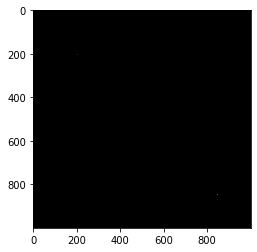

In [ ]:
plt.imshow(infos, cmap='gray')

In [ ]:
class TemporalGraphMatrixAgent(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(TemporalGraphMatrixAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.organic_views = Graph(self.config.num_products)
        self.organic_views_time = Graph(self.config.num_products)

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Adding organic session to organic view counts.
        if observation:
            previous_item = None
            for session in observation.sessions():
                current_item = session['v']
                current_time_step = session['t']
                if previous_item is not None:
                    self.organic_views_time.add(previous_item, current_item, cu)
                    self.organic_views.add(previous_item, current_item)
                previous_item = current_item

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""
        # Choosing action randomly in proportion with number of views.
        if observation is not None and len(observation.current_sessions) > 0:
            current_user = observation.current_sessions[-1]['u']
            current_items, counts = np.unique([sess['v'] for sess in observation.current_sessions], return_counts=True)
            probas = counts / np.sum(counts) # Numerical stability
            node = np.random.choice(current_items, p = probas)
            potentials = self.organic_views.adj[node, :]
            action = node
            mask = np.ones(self.config.num_products)
            #print(np.array(self.current_user_failed_reco))
            if len(self.current_user_failed_reco) > 0:
                mask[np.array(self.current_user_failed_reco)] = self.penalty
            sum_potentials = np.sum(potentials * mask)
            if sum_potentials != 0:
                next_probas = (potentials * mask) / sum_potentials
                actions = np.random.choice(np.arange(len(potentials)), p = next_probas)
            else:
                action = choice(self.config.num_products)
            #prob = self.organic_views / sum(self.organic_views)
        else:
            action = choice(self.config.num_products)#, p = prob)
        self.last_reco = action
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': 1 #prob[action]
            }
        }
    def infos(self):
        return self.organic_views.adj